# Numerical Playground

This notebook is a playground to facilitate the creation of the app: testing appropriate distributions, data generation methods, visualization routines etc.

As such, none of its content is needed to run / understand the app (which is self-contained, and better commented), but we still ship it for people that want to play with some Python functions directly without messing up with the streamlit setup.

## Data generation

Based on our b2b experience, we use a Gamma distribution as the main generating function for won deals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sps 

_Set some test parameters, print out descriptive stats and plot the empirical and theoretical dist_

In [2]:
def get_deal_distribution_by_product(
    products: list,
    shape_min: float,
    shape_max: float,
    scale_min: float,
    scale_max: float,
    n_deals: int = 1000,
    is_debug: bool = False
):
    prod2deals = {}
    shapes = np.random.uniform(shape_min, shape_max, len(products))
    scales = np.random.uniform(scale_min, scale_max, len(products))
    for idx, p in enumerate(products):
        s = np.random.gamma(shapes[idx], scales[idx], n_deals)
        prod2deals[p] = s
        if is_debug:
            print("\nProduct: {}".format(p))
            print("Mean {:.1f}, Median {:.1f}, Sum {:.1f}, Max {:.1f}".format(
                np.mean(s),
                np.median(s),
                np.sum(s),
                max(s)
            ))

    return prod2deals, shapes, scales

products = ["my_product"]
prod2deals, shapes, scales = get_deal_distribution_by_product(
    products, 
    shape_min=1.8, 
    shape_max=2.1,
    scale_min=40.0,
    scale_max=50.0, 
    n_deals=1000, 
    is_debug=True
)


Product: my_product
Mean 81.9, Median 69.0, Sum 81888.7, Max 387.4


In [3]:
def plot_gamma_with_theoretical(
    dist, # array with the distribution
    shape: float,
    scale: float
):
    # plot the empirical distribution
    count, bins, ignored = plt.hist(dist, 50, alpha=0.2, density=True)
    # plot the gamma function
    y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))
    plt.plot(bins, y, linewidth=2, color='r')  
    plt.show()

    return

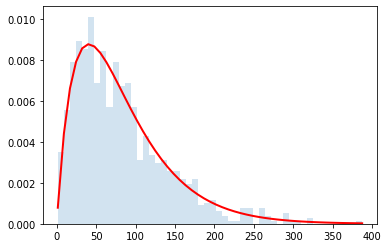

In [4]:
plot_gamma_with_theoretical(prod2deals[products[0]], shapes[0], scales[0])

_Now do the same, with N products_

In [5]:
products = ["product_{}".format(_) for _ in range(3)]
prod2deals, shapes, scales = get_deal_distribution_by_product(
    products, 
    shape_min=0.8, 
    shape_max=3.0,
    scale_min=40.0,
    scale_max=100.0, 
    n_deals=1000, 
    is_debug=True
)


Product: product_0
Mean 71.3, Median 56.2, Sum 71290.9, Max 420.8

Product: product_1
Mean 184.5, Median 163.1, Sum 184525.5, Max 789.3

Product: product_2
Mean 58.8, Median 44.8, Sum 58814.3, Max 344.0


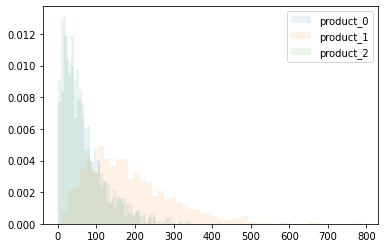

In [6]:
for p, dist in prod2deals.items():
    plt.hist(dist, 50, alpha=0.1, density=True, label=p) 

plt.legend()
plt.show()

_As an example, we dump the simulated deals in a file, which can be used for further analysis_

In [7]:
import csv

#with open('deals_data.csv', 'w', newline='') as csvfile:
    #writer = csv.DictWriter(csvfile, fieldnames=['product', 'deal_size'])
    #writer.writeheader()
    #for p, dist in prod2deals.items():
        #for d in dist.tolist():
            #writer.writerow({'product': p, 'deal_size': d})

## Simulating a future quarter / time window

Based on the empirical distribution, how much money can we expect to make in the next quarter (or whatever time period)? 

This seemingly simple question has a seemingly simple answer: number of deals we close * mean deal value. As we see below, however, the more skewed the deal distribution, the harder it is to "narrow down" which, among the possible futures, is the one likely to materialize.

In particular, point-estimates may communicate a false sense of confidence in our predictions.

In [8]:
def simulate_future_revenues(
    dist, # historical distribution
    deals_we_close: int = 10, # deal we expect to close
    possible_futures: int = 100000, # future to simulate
    with_plot: bool=True,
    is_debug: bool=True
):
    # Store sum in a list. Repeat k times. Calculate mean and std of list.
    s = [sum(np.random.choice(dist, size=deals_we_close, replace=True)) for n in range(possible_futures)]
    if is_debug:
        print("Mean {:.1f}, Median {:.1f}, Sum {:.1f}, Std {:.1f}".format(
                    np.mean(s),
                    np.median(s),
                    np.sum(s),
                    np.std(s)
                ))
    
    if with_plot:
        plt.hist(s, 50, alpha=0.5, density=True) 
        plt.show()
    
    return

Mean 711.8, Median 697.5, Sum 71178283.9, Std 185.9


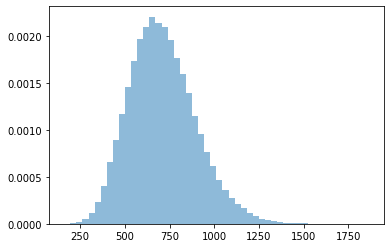

In [9]:
simulate_future_revenues(prod2deals["product_0"])


Product: product_0
Mean 33.2, Median 10.9, Sum 33171.9, Max 382.0
Mean 330.4, Median 303.2, Sum 33042643.5, Std 169.1


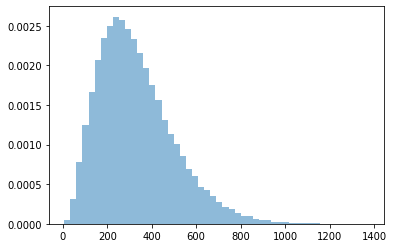

In [10]:
# play around with the distribution to see how future scenarios will change
prod2deals, shapes, scales = get_deal_distribution_by_product(
    ["product_0"], 
    shape_min=0.1, 
    shape_max=0.6,
    scale_min=90.0,
    scale_max=100.0, 
    n_deals=1000, 
    is_debug=True
)

simulate_future_revenues(prod2deals["product_0"])

## Survival analysis

When considering desired outcomes in some relatively distant future - for example, closing deals in B2B -, a common trick is establishing a threshold of interest, say, 3 months, and then calculate / predict the closing rate at 3 months after the SQL was created. 

By turning the problem into a binary classification with a fixed time horizon, however, we are now:

* incapable of making considerations for deal that are younger than the threshold. Should I wait two quarters to know how THIS quarter is going?
* incapable of adapting our closing estimates as deals age: what does deal age tell us about closing probability?

To overcome this limitation, we will use a different approach here, borrowed by what is called survival analysis (SA). In SA, the typical questions we want to answer are:

* are people that took treament A vs B dying faster? (We certainly would like to know as fast as possible the answer to this!)
* given somebody survived 5 years after getting diagnosed X, how likely is he/she to be alive in the next 3? (We certainly would like to incorporate the knowledge we have at years 5 into our current estimate)

SA, like deal closing, has to deal with an event in the future that may occur at any point in time: at any given moment, we only know what happened to deals / patients with one outcome, but have no idea about the others (NOTE: the similarity breaks down as everybody dies eventually, but not every deal closes, but the general idea will serve as a good metaphor to the introductory treatment we propose here).